<a href="https://colab.research.google.com/github/zia207/Survival_Analysis_R/blob/main/Colab_Notebook/02_07_03_03_survival_analysis_log_normal_model_r.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![All-test](http://drive.google.com/uc?export=view&id=1bLQ3nhDbZrCCqy_WCxxckOne2lgVvn3l)

# 3.3 The Log-Normal Survival Model


This tutorial covers the Log-Normal survival model, including its theoretical background, implementation in R, and practical examples using the `survival` package. We will also address common pitfalls and provide diagnostic tools to assess model fit.


## Overview


The Log-Normal survival model is a parametric model used in survival analysis where the logarithm of the survival time $T$, denoted $\ln(T)$, follows a normal distribution, i.e., $\ln(T) \sim \mathcal{N}(\mu, \sigma^2)$. Here, $\mu$ is the mean of the log-time (location parameter), and $\sigma > 0$ is the standard deviation (scale parameter). This model is part of the Accelerated Failure Time (AFT) framework, where covariates scale the survival time multiplicatively, accelerating or decelerating the time to an event (e.g., death, failure).


### Key Features


- **Hazard Function**: Unlike the exponential or Weibull models, the log-normal model has a non-monotonic hazard function that typically increases to a peak and then decreases, making it suitable for scenarios where the risk rises initially (e.g., post-surgery complications) and later declines (e.g., recovery phase). For small $\sigma$, the hazard may be monotonically decreasing.
- **Applications**: Commonly used in medical research (e.g., time to disease recurrence), reliability engineering (e.g., component failure times), or economics (e.g., duration of unemployment) when survival times are positively skewed and hazards are arc-shaped.
- **Assumptions**: Assumes $\ln(T)$ is normally distributed, implying $T$ is log-normally distributed. This is appropriate when empirical hazard plots (e.g., from Kaplan-Meier) suggest a non-monotonic or decreasing hazard.
- **Limitations**: Not suitable for monotonically increasing hazards (use Weibull instead). It does not naturally fit a proportional hazards framework like the Cox model, though it can be adapted.


- **Probability Density Function (PDF)**:

$$
  f(t) = \frac{1}{t \sigma \sqrt{2\pi}} \exp\left( -\frac{(\ln(t) - \mu)^2}{2\sigma^2} \right), \quad t > 0
$$
  This describes the distribution of survival times, skewed to the right due to the log transformation.
  
- **Survival Function**:

$$
  S(t) = 1 - \Phi\left( \frac{\ln(t) - \mu}{\sigma} \right)
$$

  where $\Phi$ is the standard normal cumulative distribution function (CDF). This gives the probability of surviving past time $t$.
  
- **Hazard Function**:

$$
  h(t) = \frac{f(t)}{S(t)} = \frac{\frac{1}{t \sigma \sqrt{2\pi}} \exp\left( -\frac{(\ln(t) - \mu)^2}{2\sigma^2} \right)}{1 - \Phi\left( \frac{\ln(t) - \mu}{\sigma} \right)}
$$
  No closed form exists, but it typically rises to a peak and then falls (arc-shaped) for \( \sigma > 1 \), or is decreasing for \( \sigma \leq 1 \).
  
- **Mean and Variance**:

  - Mean: $E[T] = e^{\mu + \sigma^2/2}$
  - Variance: $\text{Var}(T) = e^{2\mu + \sigma^2} (e^{\sigma^2} - 1)$


### When to Use


Choose the log-normal model when:

- Nonparametric hazard estimates (e.g., from Kaplan-Meier or kernel smoothing) show an arc-shaped or decreasing hazard.
- Survival times are positively skewed, and log-transformation normalizes them.
- You prefer an AFT model to interpret covariate effects as time scaling (e.g., a positive coefficient extends survival time).


### Model Fit Assessment


- Use AIC/BIC to compare with other models (e.g., Weibull, exponential).
- Check residuals (e.g., Cox-Snell) or compare fitted survival curves to Kaplan-Meier estimates.
- Validate the log-normal assumption with Q-Q plots of log-times or hazard shape diagnostics.


## Setup R in Python Runtype - Install {rpy2}
{rpy2} is a Python package that provides an interface to the R programming language, allowing Python users to run R code, call R functions, and manipulate R objects directly from Python. It enables seamless integration between Python and R, leveraging R's statistical and graphical capabilities while using Python's flexibility. The package supports passing data between the two languages and is widely used for statistical analysis, data visualization, and machine learning tasks that benefit from R's specialized libraries.

In [ ]:
!pip uninstall rpy2 -y
!pip install rpy2==3.5.1
%load_ext rpy2.ipython

Found existing installation: rpy2 3.5.17
Uninstalling rpy2-3.5.17:
  Successfully uninstalled rpy2-3.5.17
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.7/201.7 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rpy2: filename=rpy2-3.5.1-cp312-cp312-linux_x86_64.whl size=316569 sha256=610d9c596754a9519cb5831abaf30f65468abb96f7f002287a7843b807bf8385
  Stored in directory: /root/.cache/pip/wheels/00/26/d5/d5e8c0b039915e785be870270e4a9263e5058168a03513d8cc
Successfully built rpy2


## Mount Google Drive

In [ ]:
## Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Implementation in R


This tutorial demonstrates fitting a log-normal survival model using R’s `survival` package, with diagnostics to assess model fit. We’ll use the `lung` dataset from `survival`, which contains survival times for lung cancer patients. The code includes data preparation, model fitting, predictions, plotting, and diagnostics, addressing lessons from your previous queries (e.g., handling `status`, centering covariates, and robust plotting).


## Install Required R Packages


Following R packages are required to run this notebook. If any of these packages are not installed, you can install them using the code below:


In [ ]:
%%R
packages <-c(
		 'tidyverse',
		 'survival',
		 'flexsurv',
		 'survminer',
		 'ggsurvfit',
		 'tidycmprsk',
		 'ggfortify',
		 'timereg',
		 'cmprsk',
		 'condSURV',
		 'riskRegression'
		 )


## Install missing packages

In [ ]:
%R
# Install missing packages
new.packages <- packages[!(packages %in% installed.packages(lib='drive/My Drive/R/')[,"Package"])]
if(length(new.packages)) install.packages(new.packages, lib='drive/My Drive/R/')
devtools::install_github("ItziarI/WeDiBaDis", lib='drive/My Drive/R/')

## Verify installation

In [ ]:
%%R
.libPaths('drive/My Drive/R')
# Verify installation
cat("Installed packages:\n")
print(sapply(packages, requireNamespace, quietly = TRUE))

Installed packages:


  method        from 
  nobs.multinom broom



     tidyverse       survival       flexsurv      survminer      ggsurvfit 
          TRUE           TRUE           TRUE           TRUE           TRUE 
    tidycmprsk      ggfortify        timereg         cmprsk       condSURV 
          TRUE           TRUE           TRUE           TRUE           TRUE 
riskRegression 
          TRUE 


### Load Packages

In [ ]:
%%R
.libPaths('drive/My Drive/R')
# Load packages with suppressed messages
invisible(lapply(packages, function(pkg) {
  suppressPackageStartupMessages(library(pkg, character.only = TRUE))
}))

In [ ]:
%%R
# Check loaded packages
cat("Successfully loaded packages:\n")
print(search()[grepl("package:", search())])

Successfully loaded packages:
 [1] "package:riskRegression" "package:condSURV"       "package:cmprsk"        
 [4] "package:timereg"        "package:ggfortify"      "package:tidycmprsk"    
 [7] "package:ggsurvfit"      "package:survminer"      "package:ggpubr"        
[10] "package:flexsurv"       "package:survival"       "package:lubridate"     
[13] "package:forcats"        "package:stringr"        "package:dplyr"         
[16] "package:purrr"          "package:readr"          "package:tidyr"         
[19] "package:tibble"         "package:ggplot2"        "package:tidyverse"     
[22] "package:tools"          "package:stats"          "package:graphics"      
[25] "package:grDevices"      "package:utils"          "package:datasets"      
[28] "package:methods"        "package:base"          


### Data Preparation

In [ ]:
%%R
data("lung", package = "survival")
# Recode status: 1 = censored (0), 2 = dead (1)
lung$status <- lung$status - 1

# Create survival object
surv_object <- Surv(time = lung$time, event = lung$status)

### Model Fitting


- **Null Model**: `lnorm_model` fits a baseline log-normal model (`~ 1`).
- **Covariate Model**: `lnorm_model_cov` includes `age_centered` and `sex`. Coefficients represent shifts in $\mu$ (log-time); positive values extend survival time.
- **Output**: `summary(lnorm_model_cov)` shows $\mu$ (Intercept), coefficients, and $\sigma$ (Scale).


In [ ]:
%%R
# Create survival object
surv_object <- Surv(time = lung$time, event = lung$status)

# Fit log-normal models
lnorm_model <- survreg(surv_object ~ 1, data = lung, dist = "lognormal")
lnorm_model_cov <-  survreg(Surv(time, status) ~ age + sex, data = lung, dist = "lognormal")
print("Model summary (with covariates):")
summary(lnorm_model_cov)

[1] "Model summary (with covariates):"

Call:
survreg(formula = Surv(time, status) ~ age + sex, data = lung, 
    dist = "lognormal")
               Value Std. Error     z       p
(Intercept)  6.40799    0.59293 10.81 < 2e-16
age         -0.02336    0.00839 -2.78 0.00536
sex          0.51925    0.15515  3.35 0.00082
Log(scale)   0.05134    0.05602  0.92 0.35943

Scale= 1.05 

Log Normal distribution
Loglik(model)= -1158.8   Loglik(intercept only)= -1169.3
	Chisq= 21.04 on 2 degrees of freedom, p= 2.7e-05 
Number of Newton-Raphson Iterations: 3 
n= 228 



### Predictions


- **Median Time**: `type = "response"` returns $e^\mu$, the median survival time for the log-normal model.
- **Survival Probability**: Uses `plnorm` with `lower.tail = FALSE` to compute $S(t) = P(T > t)$.



In [ ]:
%%R
# Prediction for new data (60-year-old male)
new_data <- data.frame(age = 60 - mean(lung$age), sex = 1)
median_time <- predict(lnorm_model_cov, newdata = new_data, type = "response")
print("Median survival time (days):")
print(median_time)

[1] "Median survival time (days):"
       1 
1079.663 


#### Plotting


- **Survival Curve**: Compares Kaplan-Meier to the log-normal survival curve. A close match suggests good fit.
- **Lessons from Prior Errors**: Avoids issues like the `lines` error (`'x' and 'y' lengths differ`) by using a single curve with `t_seq` and `surv_lnorm`.



[1] "Survival probability at t=500 days:"
[1] 0.7676945


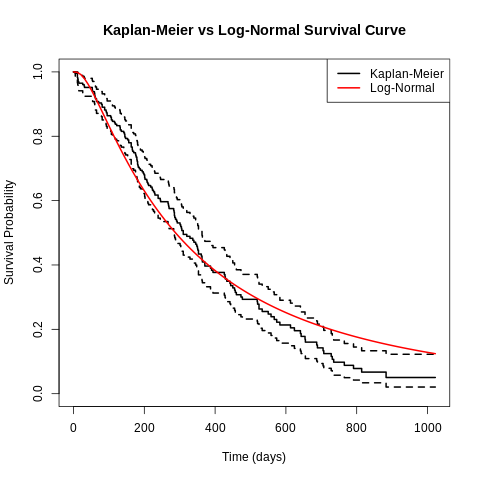

In [ ]:
%%R
# Survival probability at t=500 days
surv_prob <- plnorm(500, meanlog = predict(lnorm_model_cov, newdata = new_data, type = "lp"),
                    sdlog = lnorm_model_cov$scale, lower.tail = FALSE)
print("Survival probability at t=500 days:")
print(surv_prob)

# Plot Kaplan-Meier and log-normal curve (null model)
km_fit <- survfit(surv_object ~ 1)
plot(km_fit, main = "Kaplan-Meier vs Log-Normal Survival Curve",
     xlab = "Time (days)", ylab = "Survival Probability",
     col = "black", lwd = 2)
t_seq <- seq(0, max(lung$time), length.out = 100)
mu <- coef(lnorm_model)[1]
sigma <- lnorm_model$scale
surv_lnorm <- plnorm(t_seq, meanlog = mu, sdlog = sigma, lower.tail = FALSE)
lines(t_seq, surv_lnorm, col = "red", lwd = 2)
legend("topright", c("Kaplan-Meier", "Log-Normal"), col = c("black", "red"), lwd = 2)

### Model Diagnostics

#### Q-Q Plot for Log-Normal Assumption

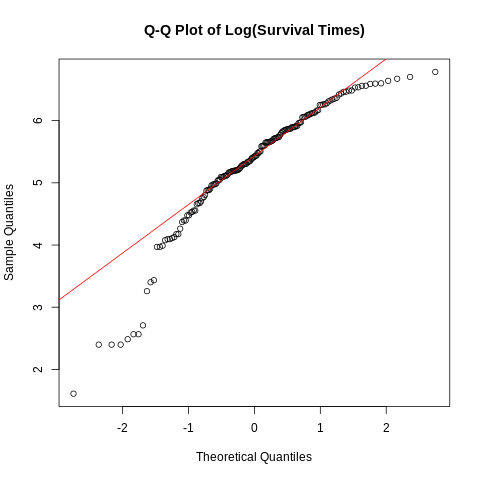

In [ ]:
%%R
# 1. Q-Q Plot for Log-Normal Assumption
log_times <- log(lung$time[lung$status == 1])  # Use event times
qqnorm(log_times, main = "Q-Q Plot of Log(Survival Times)")
qqline(log_times, col = "red")

#### Cox-Snell Residuals

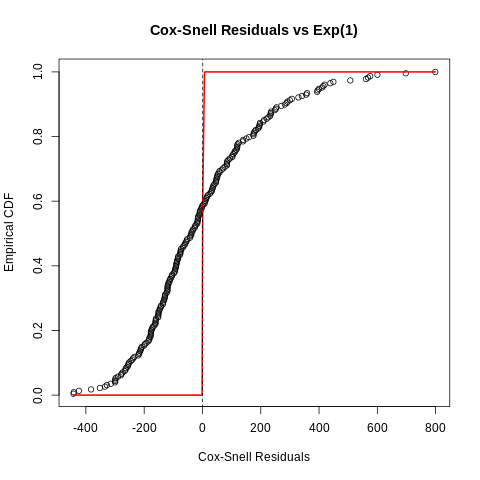

In [ ]:
%%R
# 2. Cox-Snell Residuals
residuals_cs <- (lung$time - predict(lnorm_model_cov, type = "response")) / lnorm_model_cov$scale
plot(sort(residuals_cs), (1:length(residuals_cs))/length(residuals_cs),
     main = "Cox-Snell Residuals vs Exp(1)",
     xlab = "Cox-Snell Residuals", ylab = "Empirical CDF")
lines(sort(residuals_cs), pexp(sort(residuals_cs), rate = 1), col = "red", lwd = 2)
abline(0, 1, lty = 2)

#### Hazard Function Plot

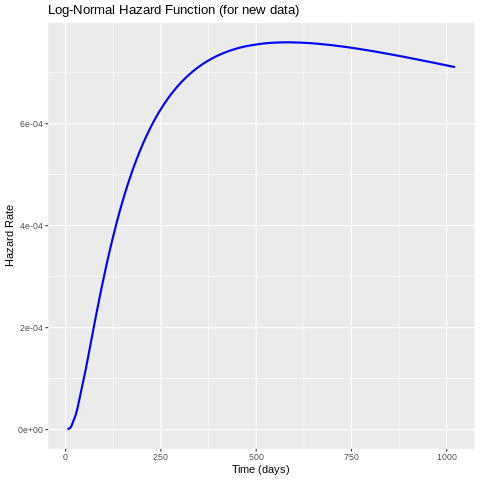

In [ ]:
%%R
# 4. Hazard Plot (using flexsurv for estimation)
library(flexsurv)
flex_lnorm <- flexsurvreg(surv_object ~ age + sex, data = lung, dist = "lnorm")
haz_lnorm <- summary(flex_lnorm, newdata = new_data, type = "hazard", tidy = TRUE)
ggplot(haz_lnorm, aes(x = time, y = est)) +
  geom_line(col = "blue", lwd = 1) +
  ggtitle("Log-Normal Hazard Function (for new data)") +
  xlab("Time (days)") + ylab("Hazard Rate")

## Summary and Conclusion


The Log-Normal survival model is a powerful parametric approach for analyzing time-to-event data, particularly when the hazard function is non-monotonic. By assuming that the logarithm of survival times follows a normal distribution, this model provides a flexible framework for understanding how covariates influence survival times through an Accelerated Failure Time (AFT) perspective.



## Resources


- **R Documentation**:
  - `survreg`: [https://rdrr.io/r/stats/survreg.html](https://rdrr.io/r/stats/survreg.html)
  - `flexsurvreg`: [https://cran.r-project.org/web/packages/flexsurv/flexsurv.pdf](https://cran.r-project.org/web/packages/flexsurv/flexsurv.pdf)
- **Books**:
  - "Survival Analysis: Techniques for Censored and Truncated Data" by Klein & Moeschberger
  - "Applied Survival Analysis" by Hosmer, Lemeshow, & May
- **Tutorials**:
  - UCLA IDRE Survival Analysis with R: [https://stats.idre.ucla.edu/r/seminars/survival-analysis-with-r/](https://stats.idre.ucla.edu/r/seminars/survival-analysis-with-r/)
  - R-bloggers: [https://www.r-bloggers.com/](https://www.r-bloggers.com/)
- **Online Courses**:
  - Coursera: "Survival Analysis in R" by Duke University
  - edX: "Survival Analysis" by Harvard University


In [ ]:
%%R
rm(list = ls())